## Database

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from skimage import img_as_ubyte

In [2]:
# Read inputs
root = 'C:/Users/nilso/Documents/EPFL/MA4/PDS Turberg/'
folder = '/Cuttings_data/'
test_name = '/MS-DB-Geo01-1/'

dirname = os.path.dirname(root)
file_path = os.path.dirname(dirname+folder) 

#ML-DB-Geo1
train_tiffs = os.listdir(file_path+test_name)

# Save figures 
save_folder = '/Figures/'
save_subfolder = '/DataProcessing/'
save_path = root + '/Paper/'+ save_folder + save_subfolder

In [3]:
# Load one example
tiff = train_tiffs[491]
image = cv2.imread(file_path + test_name + tiff, cv2.IMREAD_GRAYSCALE)

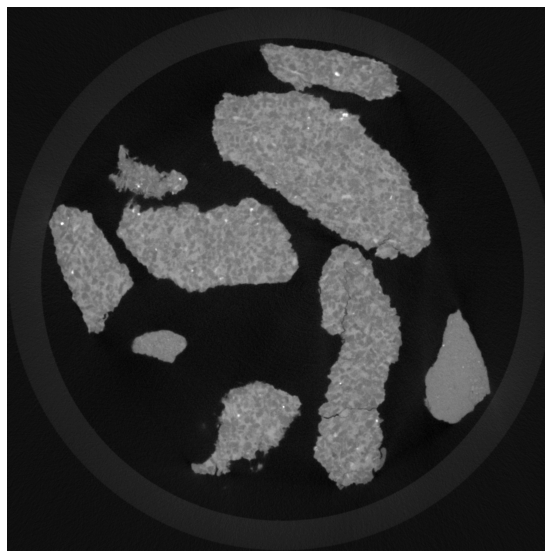

In [4]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap='gray')
plt.axis('off')
plt.savefig(save_path+'algo_1.png',bbox_inches='tight')

In [5]:
from skimage.filters import threshold_otsu
from skimage.measure import find_contours

In [6]:
def assign_mask(image):
    mask = image > threshold_otsu(image)
    return mask

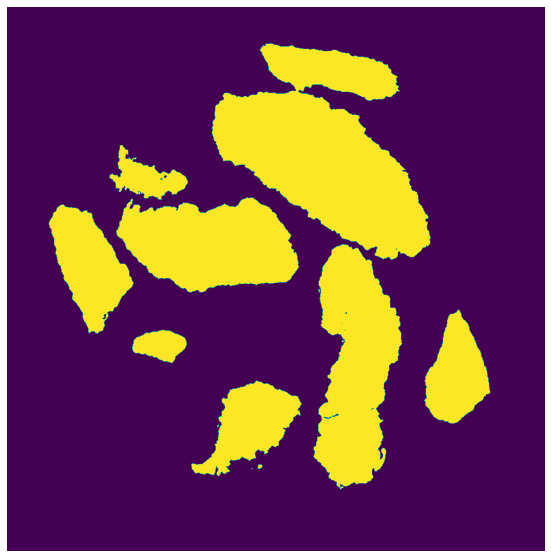

In [7]:
fig,ax = plt.subplots(figsize=(10,10))
mask = assign_mask(image)
ax.imshow(mask)
plt.axis(False)
plt.axis('off')
plt.savefig(save_path+'algo_2.png',bbox_inches='tight')

In [8]:
from skimage.morphology import disk, erosion, dilation, closing

In [9]:
selem = disk(3)

eroded = mask.copy()

for i in range(0,2):
    eroded = erosion(eroded, selem)

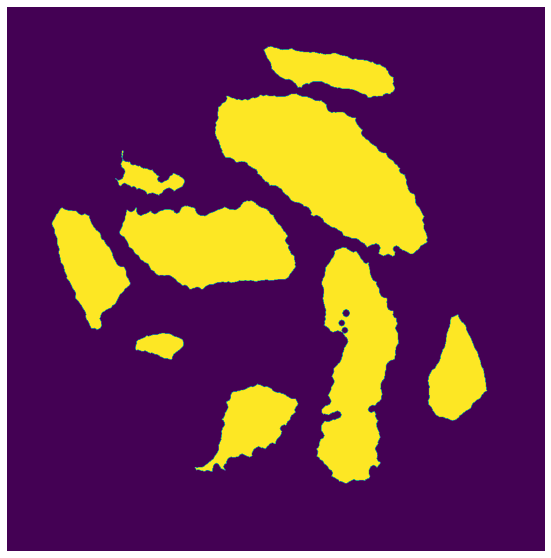

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(eroded) 
plt.axis('off')
plt.savefig(save_path+'algo_3.png',bbox_inches='tight')

In [11]:
from skimage.measure import regionprops, label

In [12]:
labels=label(eroded)

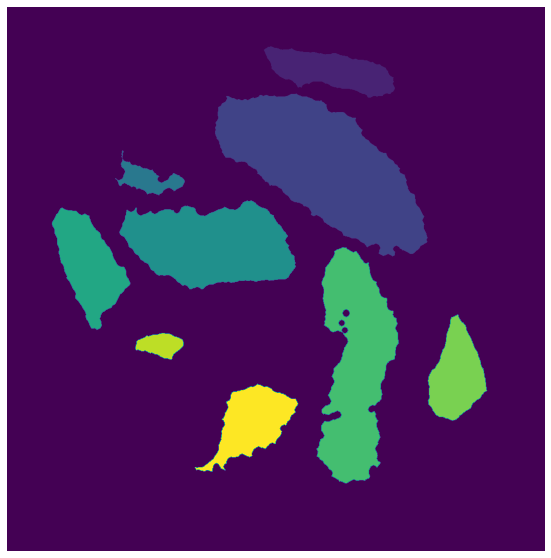

In [13]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(labels) 
plt.axis('off')
plt.savefig(save_path+'algo_4.png',bbox_inches='tight')

In [14]:
dilated = labels.copy()
for i in range(0,2):
    dilated = dilation(dilated, selem)
for i in range(0,2):    
        dilated = closing(dilated, disk(2))

In [15]:
def assign_label(mask):
    """
    Take as input a binary image abd return image with labels
    """
    selem = disk(3)

    eroded = mask.copy()

    for i in range(0,2):
        eroded = erosion(eroded, selem)
    dilated = label(eroded).copy() 
    for i in range(0,2):
        dilated = dilation(dilated, selem)
    for i in range(0,3):    
        dilated = closing(dilated, disk(1))
    return dilated

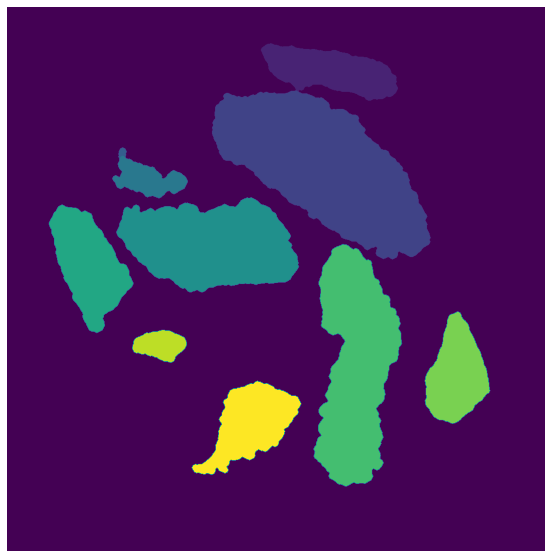

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(dilated) 
plt.axis('off')
plt.savefig(save_path+'algo_5.png',bbox_inches='tight')

In [17]:
import cv2

#### Test big samples

In [18]:
def big_cuttings(dilated,threshold=1000):
    """
    take as input an image with labels, return the fragments greater than 1000px 
    """
    big_samples = []
    for i in range(len(regionprops(dilated))):
        if regionprops(dilated)[i].area > threshold : big_samples.append(i)
    return big_samples

In [19]:
big_samples = big_cuttings(dilated)

In [20]:
len(big_samples)

9

In [21]:
def plot_samples(image,label_image,big_samples):
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
        
    ax[0].imshow(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[0].axis(False)
    ax[1].imshow(regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[1].axis(False)
    plt.show()

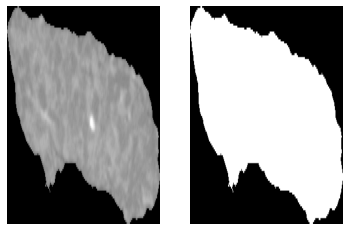

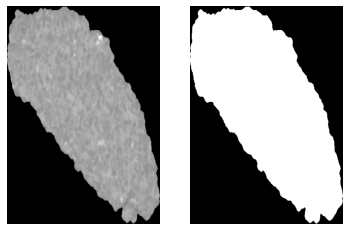

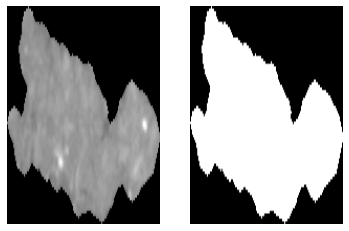

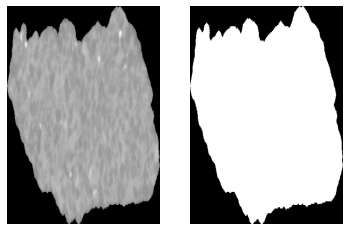

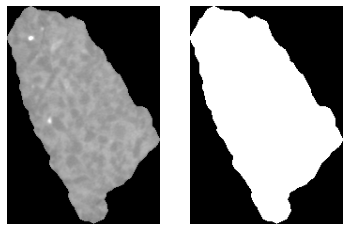

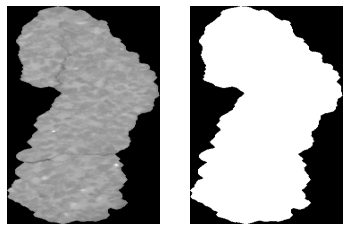

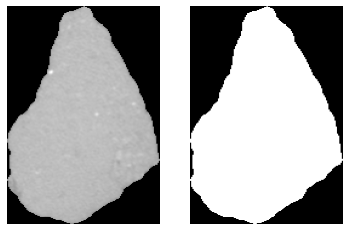

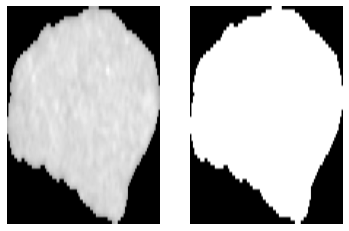

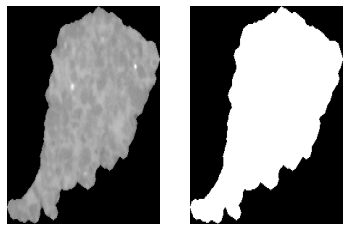

In [22]:
for im in big_samples:
    plot_samples(image,dilated,big_samples)

In [23]:
def plot_samples_resized(image,label_image,big_samples,WIDTH=128,HEIGHT=128): 
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(regionprops(label_image)[im].image.astype(np.uint8),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.tight_layout()
    plt.show()

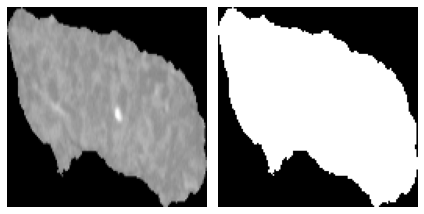

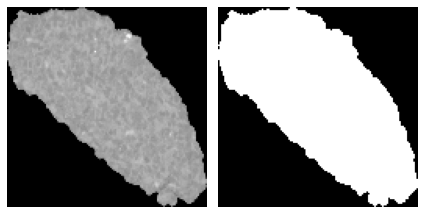

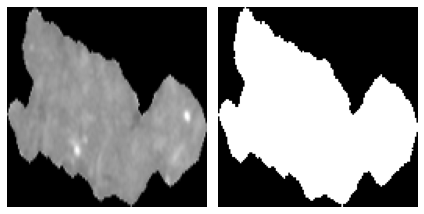

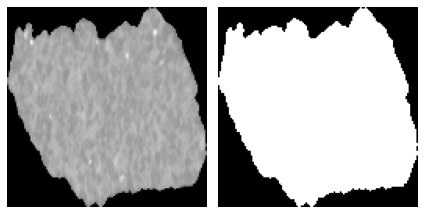

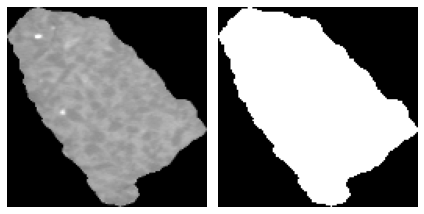

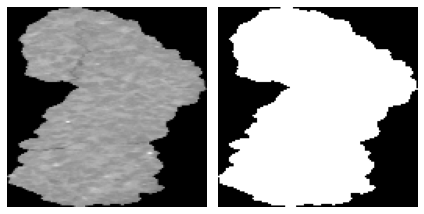

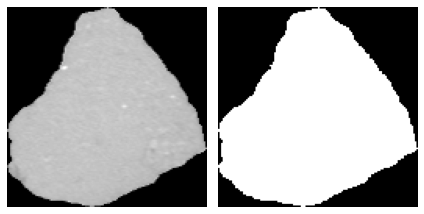

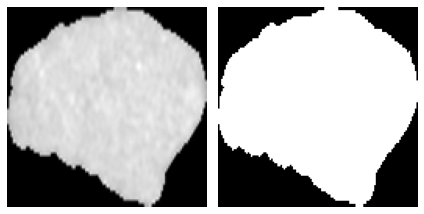

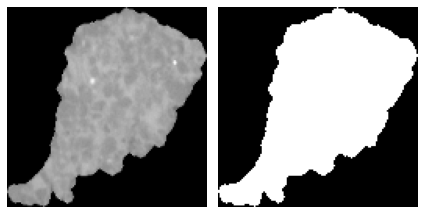

In [24]:
for im in big_samples:
    plot_samples_resized(image,dilated,big_samples)

#### Crop Rectangle function

In [25]:
def crop_rectangle(im_rect,box,rect):
    W = rect[1][0]
    H = rect[1][1]
    
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    rotated = False
    angle = rect[2]
    
    if angle < -45:
        angle+=90
        rotated = True
        
    size = (x2-x1,y2-y1)
    center = (int((x1+x2)/2), int((y1+y2)/2))
    
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    
    cropped = cv2.getRectSubPix(im_rect, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)
    
    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W
    
    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    return croppedRotated

In [26]:
def plot_rectangular_samples_resized(image,dilated,big_samples,WIDTH = 128,HEIGHT = 128):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
        
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(crop_rectangle(im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(crop_rectangle(image*im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.show()

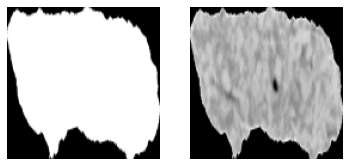

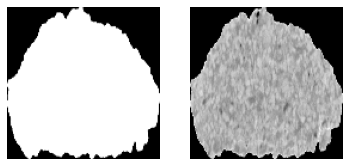

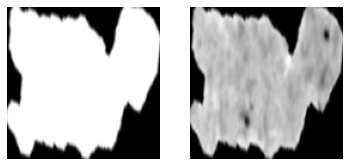

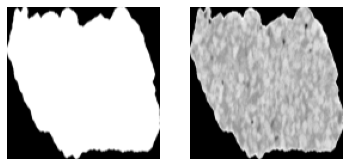

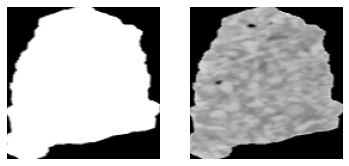

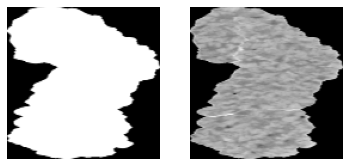

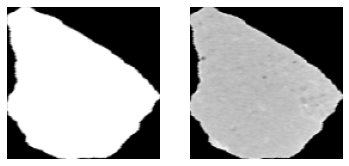

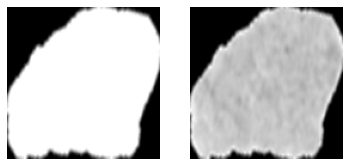

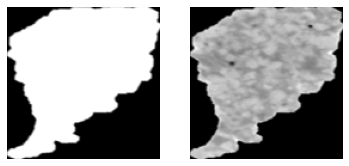

In [27]:
for im in big_samples :
    plot_rectangular_samples_resized(image,dilated,big_samples)

#### Figure with Bbox

(-0.5, 1038.5, 1050.5, -0.5)

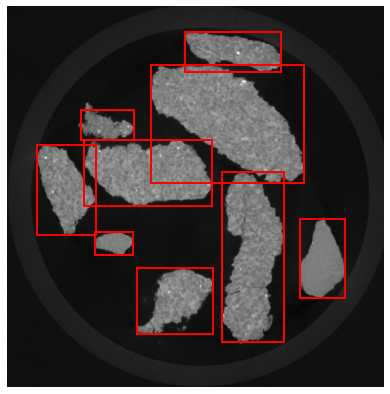

In [28]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    # draw bbox
    minr, minc, maxr, maxc = regionprops(dilated)[im].bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    
    ax.add_patch(rect)
ax.imshow(image,cmap='gray')
plt.axis(False)

#### Figure with rectangle

(-0.5, 1038.5, 1050.5, -0.5)

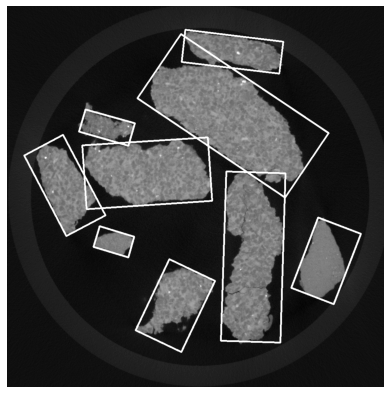

In [29]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    im_rect = (dilated == regionprops(dilated)[im].label).astype(np.uint8)
    
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    im = cv2.drawContours(rect_image,[box],0,(255,0,0),4)
ax.imshow(im,cmap='gray')
plt.axis(False)

#### Figure with rectangle and bbox

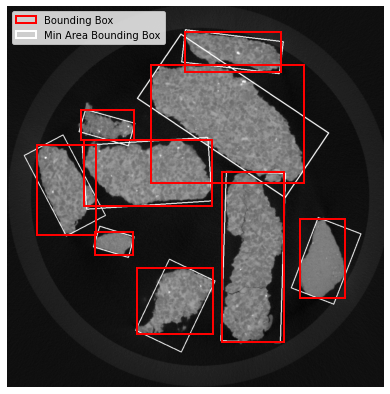

In [30]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    # draw rectangle
    im_rect = (dilated == regionprops(dilated)[im].label).astype(np.uint8)
    
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #box_array.append(box) 
    
    # draw bbox
    minr, minc, maxr, maxc = regionprops(dilated)[im].bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    
    ax.add_patch(rect)
    im = cv2.drawContours(rect_image,[box],0,(255,0,0),thickness=2)
ax.imshow(im,cmap='gray')
plt.axis(False)
leg = plt.gca().legend(('Bounding Box','Min Area Bounding Box'))
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('white')